In [1]:
!pip install timm
!pip install albumentations
!pip install segmentation_models_pytorch
!pip install monai
!pip install imageio
!pip install pydicom
!pip install pandas
!pip install nibabel
!pip install matplotlib
!pip install torch
!pip install cv
!pip install pylibjpeg==1.4.0
!pip install python_gdcm==3.0.17.1
!pip install pylibjpeg-libjpeg


In [1]:
import os
import sys
import gc
import ast
import cv2
import imageio
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from monai.transforms import Resize
import  monai.transforms as transforms

%matplotlib inline


/home/jovyan/MLDS_project/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True
kernel_type = 'timm3d_manet_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

DEBUG = False
image_sizes = [128, 128, 128]
R = Resize(image_sizes)

init_lr = 3e-4
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1

data_dir = './Dataset/'
use_amp = True
num_workers = 4
out_dim = 7

n_epochs = 10

log_dir = './logs'
model_dir = './my_models'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [3]:
transforms_train = transforms.Compose([
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
    transforms.RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),
    transforms.RandAffined(keys=["image", "mask"], translate_range=[int(x*y) for x, y in zip(image_sizes, [0.3, 0.3, 0.3])], padding_mode='zeros', prob=0.7),
    transforms.RandGridDistortiond(keys=("image", "mask"), prob=0.5, distort_limit=(-0.01, 0.01), mode="nearest"),    
])

transforms_valid = transforms.Compose([
])

In [4]:
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))

mask_files = os.listdir(f'{data_dir}/segmentations')
df_mask = pd.DataFrame({
    'mask_file': mask_files,
})
df_mask['StudyInstanceUID'] = df_mask['mask_file'].apply(lambda x: x[:-4])
df_mask['mask_file'] = df_mask['mask_file'].apply(lambda x: os.path.join(data_dir, 'segmentations', x))
df = df_train.merge(df_mask, on='StudyInstanceUID', how='left')
df['image_folder'] = df['StudyInstanceUID'].apply(lambda x: os.path.join(data_dir, 'train_images', x))
df['mask_file'].fillna('', inplace=True)

df_seg = df.query('mask_file != ""').reset_index(drop=True)

kf = KFold(5)
df_seg['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_seg, df_seg)):
    df_seg.loc[valid_idx, 'fold'] = fold

df_seg.tail()

/tmp/ipykernel_5028/2212733997.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['mask_file'].fillna('', inplace=True)


,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,fold
82,1.2.826.0.1.3680043.32071,1,0,1,0,1,0,1,1,./Dataset/segmentations/1.2.826.0.1.3680043.32...,./Dataset/train_images/1.2.826.0.1.3680043.32071,4
83,1.2.826.0.1.3680043.30524,1,0,0,0,0,0,1,1,./Dataset/segmentations/1.2.826.0.1.3680043.30...,./Dataset/train_images/1.2.826.0.1.3680043.30524,4
84,1.2.826.0.1.3680043.28025,0,0,0,0,0,0,0,0,./Dataset/segmentations/1.2.826.0.1.3680043.28...,./Dataset/train_images/1.2.826.0.1.3680043.28025,4
85,1.2.826.0.1.3680043.21321,1,1,1,1,0,0,0,1,./Dataset/segmentations/1.2.826.0.1.3680043.21...,./Dataset/train_images/1.2.826.0.1.3680043.21321,4
86,1.2.826.0.1.3680043.26990,1,0,0,0,0,1,1,1,./Dataset/segmentations/1.2.826.0.1.3680043.26...,./Dataset/train_images/1.2.826.0.1.3680043.26990,4


In [5]:
df_seg

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,mask_file,image_folder,fold
0,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,./Dataset/segmentations/1.2.826.0.1.3680043.13...,./Dataset/train_images/1.2.826.0.1.3680043.1363,0
1,1.2.826.0.1.3680043.25704,0,0,0,0,0,0,0,0,./Dataset/segmentations/1.2.826.0.1.3680043.25...,./Dataset/train_images/1.2.826.0.1.3680043.25704,0
2,1.2.826.0.1.3680043.20647,0,0,0,0,0,0,0,0,./Dataset/segmentations/1.2.826.0.1.3680043.20...,./Dataset/train_images/1.2.826.0.1.3680043.20647,0
3,1.2.826.0.1.3680043.31077,1,0,0,1,1,1,1,0,./Dataset/segmentations/1.2.826.0.1.3680043.31...,./Dataset/train_images/1.2.826.0.1.3680043.31077,0
4,1.2.826.0.1.3680043.17960,0,0,0,0,0,0,0,0,./Dataset/segmentations/1.2.826.0.1.3680043.17...,./Dataset/train_images/1.2.826.0.1.3680043.17960,0
...,...,...,...,...,...,...,...,...,...,...,...,...
82,1.2.826.0.1.3680043.32071,1,0,1,0,1,0,1,1,./Dataset/segmentations/1.2.826.0.1.3680043.32...,./Dataset/train_images/1.2.826.0.1.3680043.32071,4
83,1.2.826.0.1.3680043.30524,1,0,0,0,0,0,1,1,./Dataset/segmentations/1.2.826.0.1.3680043.30...,./Dataset/train_images/1.2.826.0.1.3680043.30524,4
84,1.2.826.0.1.3680043.28025,0,0,0,0,0,0,0,0,./Dataset/segmentations/1.2.826.0.1.3680043.28...,./Dataset/train_images/1.2.826.0.1.3680043.28025,4
85,1.2.826.0.1.3680043.21321,1,1,1,1,0,0,0,1,./Dataset/segmentations/1.2.826.0.1.3680043.21...,./Dataset/train_images/1.2.826.0.1.3680043.21321,4


In [6]:
revert_list = [
    '1.2.826.0.1.3680043.1363',
    '1.2.826.0.1.3680043.20120',
    '1.2.826.0.1.3680043.2243',
    '1.2.826.0.1.3680043.24606',
    '1.2.826.0.1.3680043.32071'
]

In [7]:
def load_dicom(path):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    data = cv2.resize(data, (image_sizes[0], image_sizes[1]), interpolation = cv2.INTER_LINEAR)
    return data


def load_dicom_line_par(path):

    t_paths = sorted(glob(os.path.join(path, "*")),
       key=lambda x: int(x.split('/')[-1].split(".")[0]))

    n_scans = len(t_paths)
    indices = np.quantile(list(range(n_scans)), np.linspace(0., 1., image_sizes[2])).round().astype(int)
    t_paths = [t_paths[i] for i in indices]

    images = []
    for filename in t_paths:
        images.append(load_dicom(filename))
    images = np.stack(images, -1)
    
    images = images - np.min(images)
    images = images / (np.max(images) + 1e-4)
    images = (images * 255).astype(np.uint8)

    return images


def load_sample(row, has_mask=True):

    image = load_dicom_line_par(row.image_folder)
    if image.ndim < 4:
        image = np.expand_dims(image, 0).repeat(3, 0)  # to 3ch

    if has_mask:
        mask_org = nib.load(row.mask_file).get_fdata()
        shape = mask_org.shape
        mask_org = mask_org.transpose(1, 0, 2)[::-1, :, ::-1]  # (d, w, h)
        mask = np.zeros((7, shape[0], shape[1], shape[2]))
        for cid in range(7):
            mask[cid] = (mask_org == (cid+1))
        mask = mask.astype(np.uint8) * 255
        mask = R(mask).numpy()
        
        return image, mask
    else:
        return image



class SEGDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        
        
        ### using local cache
#         image_file = os.path.join(data_dir, f'{row.StudyInstanceUID}.npy')
#         mask_file = os.path.join(data_dir, f'{row.StudyInstanceUID}_mask.npy')
#         image = np.load(image_file).astype(np.float32)
#         mask = np.load(mask_file).astype(np.float32)

        image, mask = load_sample(row, has_mask=True)
    
        if row.StudyInstanceUID in revert_list:
            mask = mask[:, :, :, ::-1]

        res = self.transform({'image':image, 'mask':mask})
        image = res['image'] / 255.
        mask = res['mask']
        mask = (mask > 127).astype(np.float32)

        image, mask = torch.tensor(image).float(), torch.tensor(mask).float()

        return image, mask

In [8]:
rcParams['figure.figsize'] = 20,8

df_show = df_seg
dataset_show = SEGDataset(df_show, 'train', transform=transforms_train)

/tmp/ipykernel_893/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()


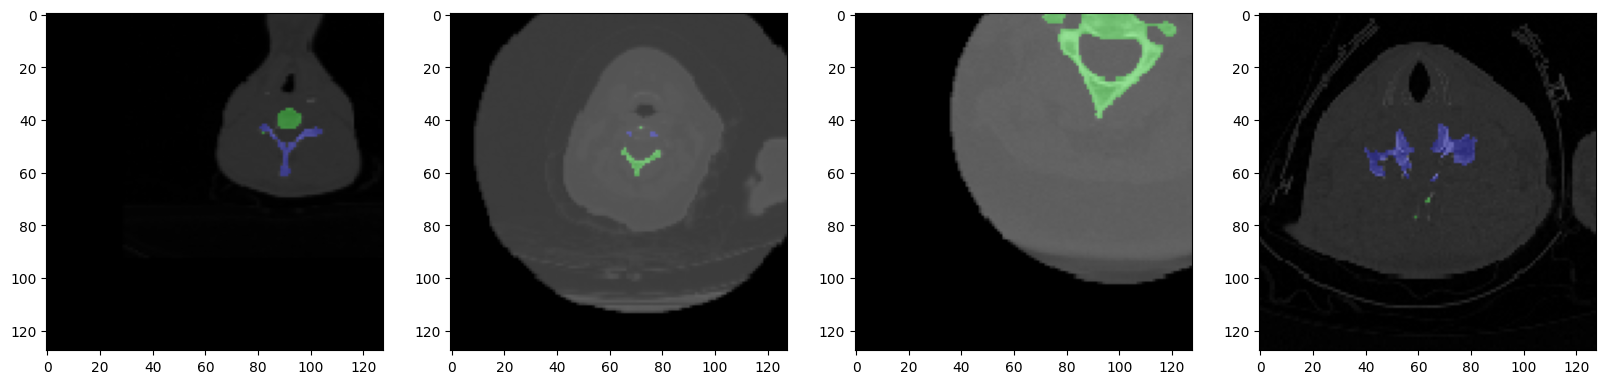

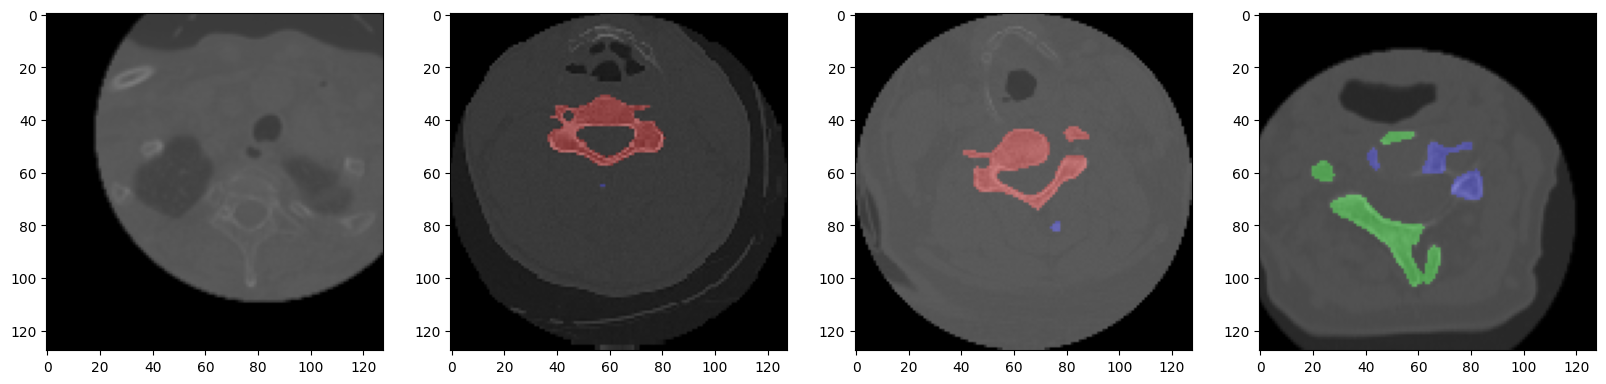

In [11]:
for i in range(2):
    f, axarr = plt.subplots(1,4)
    for p in range(4):
        idx = i*4+p
        img, mask = dataset_show[idx]
        img = img[:, :, :, 60]
        mask = mask[:, :, :, 60]
        mask[0] = mask[0] + mask[3] + mask[6]
        mask[1] = mask[1] + mask[4]
        mask[2] = mask[2] + mask[5]
        mask = mask[:3]
        img = img * 0.7 + mask * 0.3
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())

<h2> Model</h2>

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from segmentation_models_pytorch.base import modules as md


class PAB(nn.Module):
    def __init__(self, in_channels, out_channels, pab_channels=64):
        super(PAB, self).__init__()
        # Series of 1x1 conv to generate attention feature maps
        self.pab_channels = pab_channels
        self.in_channels = in_channels
        self.top_conv = nn.Conv2d(in_channels, pab_channels, kernel_size=1)
        self.center_conv = nn.Conv2d(in_channels, pab_channels, kernel_size=1)
        self.bottom_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.map_softmax = nn.Softmax(dim=1)
        self.out_conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        bsize = x.size()[0]
        h = x.size()[2]
        w = x.size()[3]
        d = x.size()[4]
        x_top = self.top_conv(x)
        x_center = self.center_conv(x)
        x_bottom = self.bottom_conv(x)

        x_top = x_top.flatten(2)
        x_center = x_center.flatten(2).transpose(1, 2)
        x_bottom = x_bottom.flatten(2).transpose(1, 2)
        sp_map = torch.matmul(x_center, x_top)
        sp_map = self.map_softmax(sp_map.view(bsize, -1)).view(bsize, h*w*d, h*w*d)
        sp_map = torch.matmul(sp_map, x_bottom)
        sp_map = sp_map.reshape(bsize, self.in_channels, h, w, d)
        x = x + sp_map
        x = self.out_conv(x)
        # print('x_top',x_top.shape,'x_center',x_center.shape,'x_bottom',x_bottom.shape,'x',x.shape,'sp_map',sp_map.shape)
        return x


class MFAB(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, use_batchnorm=True, reduction=16):
        # MFAB is just a modified version of SE-blocks, one for skip, one for input
        super(MFAB, self).__init__()
        self.hl_conv = nn.Sequential(
            md.Conv2dReLU(
                in_channels,
                in_channels,
                kernel_size=3,
                padding=1,
                use_batchnorm=use_batchnorm,
            ),
            md.Conv2dReLU(
                in_channels,
                skip_channels,
                kernel_size=1,
                use_batchnorm=use_batchnorm,
            ),
        )
        reduced_channels = max(1, skip_channels // reduction)
        self.SE_ll = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(skip_channels, reduced_channels, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, skip_channels, 1),
            nn.Sigmoid(),
        )
        self.SE_hl = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(skip_channels, reduced_channels, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(reduced_channels, skip_channels, 1),
            nn.Sigmoid(),
        )
        self.conv1 = md.Conv2dReLU(
            skip_channels + skip_channels,  # we transform C-prime form high level to C from skip connection
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )

    def forward(self, x, skip=None):
        x = self.hl_conv(x)
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        attention_hl = self.SE_hl(x)
        if skip is not None:
            attention_ll = self.SE_ll(skip)
            attention_hl = attention_hl + attention_ll
            x = x * attention_hl
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, use_batchnorm=True):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class MAnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        reduction=16,
        use_batchnorm=True,
        pab_channels=64,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]

        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        self.center = PAB(head_channels, head_channels, pab_channels=pab_channels)

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm)  # no attention type here
        blocks = [
            MFAB(in_ch, skip_ch, out_ch, reduction=reduction, **kwargs)
            if skip_ch > 0
            else DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        # for the last we dont have skip connection -> use simple decoder block
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [11]:
class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='manet', pretrained=False):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )
        g = self.encoder(torch.rand(1, 3, 64, 64))
        encoder_channels = [1] + [_.shape[1] for _ in g]
        decoder_channels = [256, 128, 64, 32, 16]
        if segtype == 'manet':
            self.decoder = MAnetDecoder(
                encoder_channels = encoder_channels[:n_blocks+1],
                decoder_channels=decoder_channels[:n_blocks],
                n_blocks=n_blocks,
            )

        self.segmentation_head = nn.Conv2d(decoder_channels[n_blocks-1], out_dim, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

    def forward(self,x):
        global_features = [0] + self.encoder(x)[:n_blocks]
        seg_features = self.decoder(*global_features)
        seg_features = self.segmentation_head(seg_features)
        return seg_features

In [12]:
""" Conv3d w/ Same Padding
modified from:
https://github.com/rwightman/pytorch-image-models/blob/a2727c1bf78ba0d7b5727f5f95e37fb7f8866b1f/timm/models/layers/conv2d_same.py
https://github.com/rwightman/pytorch-image-models/blob/a2727c1bf78ba0d7b5727f5f95e37fb7f8866b1f/timm/models/layers/padding.py
"""
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Optional, List


# Calculate symmetric padding for a convolution
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x: int, k: int, s: int, d: int):
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)


# Can SAME padding for given args be done statically?
def is_static_pad(kernel_size: int, stride: int = 1, dilation: int = 1, **_):
    return stride == 1 and (dilation * (kernel_size - 1)) % 2 == 0


# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, k: List[int], s: List[int], d: List[int] = (1, 1, 1), value: float = 0):
    ih, iw, iz = x.size()[-3:]
    pad_h = get_same_padding(ih, k[0], s[0], d[0])
    pad_w = get_same_padding(iw, k[1], s[1], d[1])
    pad_z = get_same_padding(iz, k[2], s[2], d[2])
    if pad_h > 0 or pad_w > 0 or pad_z > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2, pad_z // 2, pad_z - pad_z // 2], value=value)
    return x


def get_padding_value(padding, kernel_size, **kwargs) -> Tuple[Tuple, bool]:
    dynamic = False
    if isinstance(padding, str):
        # for any string padding, the padding will be calculated for you, one of three ways
        padding = padding.lower()
        if padding == 'same':
            # TF compatible 'SAME' padding, has a performance and GPU memory allocation impact
            if is_static_pad(kernel_size, **kwargs):
                # static case, no extra overhead
                padding = get_padding(kernel_size, **kwargs)
            else:
                # dynamic 'SAME' padding, has runtime/GPU memory overhead
                padding = 0
                dynamic = True
        elif padding == 'valid':
            # 'VALID' padding, same as padding=0
            padding = 0
        else:
            # Default to PyTorch style 'same'-ish symmetric padding
            padding = get_padding(kernel_size, **kwargs)
    return padding, dynamic


def conv3d_same(
        x, weight: torch.Tensor, bias: Optional[torch.Tensor] = None, stride: Tuple[int, int, int] = (1, 1, 1),
        padding: Tuple[int, int, int] = (0, 0, 0), dilation: Tuple[int, int, int] = (1, 1, 1), groups: int = 1):
    x = pad_same(x, weight.shape[-3:], stride, dilation)
    return F.conv3d(x, weight, bias, stride, (0, 0, 0), dilation, groups)


class Conv3dSame(nn.Conv3d):
    """ Tensorflow like 'SAME' convolution wrapper for 3d convolutions
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv3dSame, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        return conv3d_same(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


def create_conv3d_pad(in_chs, out_chs, kernel_size, **kwargs):
    padding = kwargs.pop('padding', '')
    kwargs.setdefault('bias', False)
    padding, is_dynamic = get_padding_value(padding, kernel_size, **kwargs)
    if is_dynamic:
        return Conv3dSame(in_chs, out_chs, kernel_size, **kwargs)
    else:
        return nn.Conv3d(in_chs, out_chs, kernel_size, padding=padding, **kwargs)

In [13]:
from timm.layers.conv2d_same import Conv2dSame, conv2d_same
# from conv3d_same import Conv3dSame


def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output




In [14]:
m = TimmSegModel(backbone)
m = convert_3d(m)
m(torch.rand(1, 3, 128,128,128)).shape

torch.Size([1, 7, 128, 128, 128])

<h2>Loss & Metric</h2>

In [15]:
from typing import Any, Dict, Optional


def binary_dice_score(
    y_pred: torch.Tensor,
    y_true: torch.Tensor,
    threshold: Optional[float] = None,
    nan_score_on_empty=False,
    eps: float = 1e-7,
) -> float:

    if threshold is not None:
        y_pred = (y_pred > threshold).to(y_true.dtype)

    intersection = torch.sum(y_pred * y_true).item()
    cardinality = (torch.sum(y_pred) + torch.sum(y_true)).item()

    score = (2.0 * intersection) / (cardinality + eps)

    has_targets = torch.sum(y_true) > 0
    has_predicted = torch.sum(y_pred) > 0

    if not has_targets:
        if nan_score_on_empty:
            score = np.nan
        else:
            score = float(not has_predicted)
    return score


def multilabel_dice_score(
    y_true: torch.Tensor,
    y_pred: torch.Tensor,
    threshold=None,
    eps=1e-7,
    nan_score_on_empty=False,
):
    ious = []
    num_classes = y_pred.size(0)
    for class_index in range(num_classes):
        iou = binary_dice_score(
            y_pred=y_pred[class_index],
            y_true=y_true[class_index],
            threshold=threshold,
            nan_score_on_empty=nan_score_on_empty,
            eps=eps,
        )
        ious.append(iou)

    return ious


def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


def bce_dice(input, target, loss_weights=loss_weights):
    loss1 = loss_weights[0] * nn.BCEWithLogitsLoss()(input, target)
    loss2 = loss_weights[1] * dice_loss(input, target)
    return (loss1 + loss2) / sum(loss_weights)

criterion = bce_dice

<h2>Train & Valid func</h2>

In [16]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, gt_masks in bar:
        optimizer.zero_grad()
        images = images.cuda()
        gt_masks = gt_masks.cuda()

        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, gt_masks, gt_masks_sfl, lam = mixup(images, gt_masks)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, gt_masks)
            if do_mixup:
                loss2 = criterion(logits, gt_masks_sfl)
                loss = loss * lam  + loss2 * (1 - lam)

        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    outputs = []
    ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    batch_metrics = [[]] * 7
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, gt_masks in bar:
            images = images.cuda()
            gt_masks = gt_masks.cuda()

            logits = model(images)
            loss = criterion(logits, gt_masks)
            valid_loss.append(loss.item())
            for thi, th in enumerate(ths):
                pred = (logits.sigmoid() > th).float().detach()
                for i in range(logits.shape[0]):
                    tmp = multilabel_dice_score(
                        y_pred=logits[i].sigmoid().cpu(),
                        y_true=gt_masks[i].cpu(),
                        threshold=0.5,
                    )
                    batch_metrics[thi].extend(tmp)
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')
            
    metrics = [np.mean(this_metric) for this_metric in batch_metrics]
    print('best th:', ths[np.argmax(metrics)], 'best dc:', np.max(metrics))

    return np.mean(valid_loss), np.max(metrics)

/home/jovyan/MLDS_project/myenv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/jovyan/MLDS_project/myenv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable

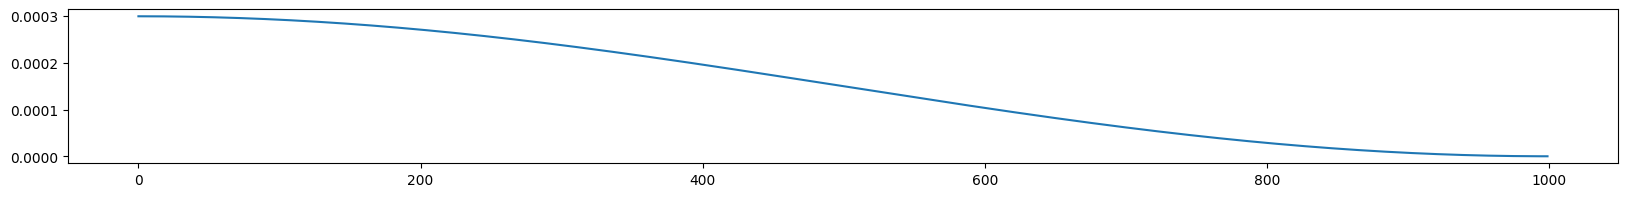

In [17]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)
lrs = []
for epoch in range(1, 1000+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

<h2>Training</h2>

In [21]:
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    train_losses = []
    valid_losses = []
    metrics = []

    for epoch in range(1, n_epochs+1):
        scheduler_cosine.step(epoch-1)

        print(time.ctime(), 'Epoch:', epoch)

        train_loss = train_func(model, loader_train, optimizer, scaler)
        valid_loss, metric = valid_func(model, loader_valid)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        metrics.append(metric)

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric > metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )
    
    # Plot losses
    # Plot losses and metrics
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.title(f'Fold {fold} Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics, label='Validation Metric')
    plt.title(f'Fold {fold} Metric')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'losses_and_metrics_fold_{fold}.png')
    plt.show()

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [19]:
# run(0)
# run(1)


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18d.ra2_in1k)
INFO:timm.models._hub:[timm/resnet18d.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


70 17
Sat May 18 12:42:34 2024 Epoch: 1


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 9.401636134435131e-05
Sat May 18 13:29:22 2024 Fold 2, Epoch 1, lr: 0.0003000, train loss: 0.65702, valid loss: 0.53722, metric: 0.000094.
metric_best (0.000000 --> 0.000094). Saving model ...
Sat May 18 13:29:23 2024 Epoch: 2


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.035424031948031884
Sat May 18 14:16:10 2024 Fold 2, Epoch 2, lr: 0.0002927, train loss: 0.52678, valid loss: 0.49886, metric: 0.035424.
metric_best (0.000094 --> 0.035424). Saving model ...
Sat May 18 14:16:11 2024 Epoch: 3


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.09388088800506664
Sat May 18 14:59:06 2024 Fold 2, Epoch 3, lr: 0.0002714, train loss: 0.49092, valid loss: 0.48618, metric: 0.093881.
metric_best (0.035424 --> 0.093881). Saving model ...
Sat May 18 14:59:07 2024 Epoch: 4


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.15198926878676322
Sat May 18 15:36:29 2024 Fold 2, Epoch 4, lr: 0.0002382, train loss: 0.47184, valid loss: 0.47970, metric: 0.151989.
metric_best (0.093881 --> 0.151989). Saving model ...
Sat May 18 15:36:29 2024 Epoch: 5


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.1670779642948692
Sat May 18 16:23:02 2024 Fold 2, Epoch 5, lr: 0.0001964, train loss: 0.45155, valid loss: 0.44645, metric: 0.167078.
metric_best (0.151989 --> 0.167078). Saving model ...
Sat May 18 16:23:02 2024 Epoch: 6


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.15637483311637895
Sat May 18 17:05:00 2024 Fold 2, Epoch 6, lr: 0.0001500, train loss: 0.43338, valid loss: 0.43719, metric: 0.156375.
Sat May 18 17:05:01 2024 Epoch: 7


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.24487682755403042
Sat May 18 17:48:39 2024 Fold 2, Epoch 7, lr: 0.0001036, train loss: 0.41033, valid loss: 0.40149, metric: 0.244877.
metric_best (0.167078 --> 0.244877). Saving model ...
Sat May 18 17:48:40 2024 Epoch: 8


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.2642449025832354
Sat May 18 18:33:21 2024 Fold 2, Epoch 8, lr: 0.0000618, train loss: 0.38768, valid loss: 0.38517, metric: 0.264245.
metric_best (0.244877 --> 0.264245). Saving model ...
Sat May 18 18:33:22 2024 Epoch: 9


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.2702205217126899
Sat May 18 19:15:47 2024 Fold 2, Epoch 9, lr: 0.0000286, train loss: 0.38463, valid loss: 0.38051, metric: 0.270221.
metric_best (0.264245 --> 0.270221). Saving model ...
Sat May 18 19:15:48 2024 Epoch: 10


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_5028/234965088.py:81: UserWarnin

best th: 0.2 best dc: 0.27290530066935176
Sat May 18 19:59:05 2024 Fold 2, Epoch 10, lr: 0.0000073, train loss: 0.38830, valid loss: 0.37728, metric: 0.272905.
metric_best (0.270221 --> 0.272905). Saving model ...


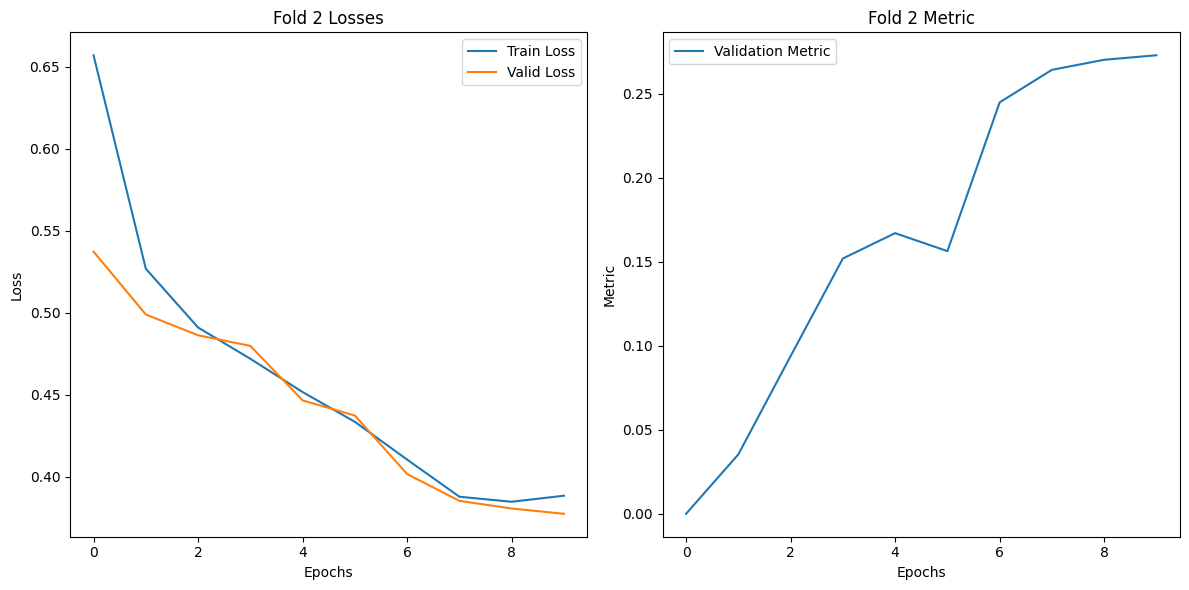

In [22]:
run(2)

In [38]:
# run(3)

70 17
Sun May 12 17:43:02 2024 Epoch: 1


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.00027754991984714294
Sun May 12 18:11:58 2024 Fold 3, Epoch 1, lr: 0.0003000, train loss: 0.67675, valid loss: 0.58200, metric: 0.000278.
metric_best (0.000000 --> 0.000278). Saving model ...
Sun May 12 18:11:58 2024 Epoch: 2


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.00037511827861450296
Sun May 12 18:37:07 2024 Fold 3, Epoch 2, lr: 0.0002927, train loss: 0.54069, valid loss: 0.53919, metric: 0.000375.
metric_best (0.000278 --> 0.000375). Saving model ...
Sun May 12 18:37:07 2024 Epoch: 3


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.05272905467791157
Sun May 12 19:03:16 2024 Fold 3, Epoch 3, lr: 0.0002714, train loss: 0.50381, valid loss: 0.49905, metric: 0.052729.
metric_best (0.000375 --> 0.052729). Saving model ...
Sun May 12 19:03:17 2024 Epoch: 4


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.11436232413979562
Sun May 12 19:27:02 2024 Fold 3, Epoch 4, lr: 0.0002382, train loss: 0.47429, valid loss: 0.47209, metric: 0.114362.
metric_best (0.052729 --> 0.114362). Saving model ...
Sun May 12 19:27:02 2024 Epoch: 5


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.16821121103105904
Sun May 12 19:51:08 2024 Fold 3, Epoch 5, lr: 0.0001964, train loss: 0.44736, valid loss: 0.44264, metric: 0.168211.
metric_best (0.114362 --> 0.168211). Saving model ...
Sun May 12 19:51:08 2024 Epoch: 6


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.15517211253976143
Sun May 12 20:17:04 2024 Fold 3, Epoch 6, lr: 0.0001500, train loss: 0.41962, valid loss: 0.42545, metric: 0.155172.
Sun May 12 20:17:04 2024 Epoch: 7


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.18806653830422593
Sun May 12 20:42:56 2024 Fold 3, Epoch 7, lr: 0.0001036, train loss: 0.38946, valid loss: 0.40891, metric: 0.188067.
metric_best (0.168211 --> 0.188067). Saving model ...
Sun May 12 20:42:57 2024 Epoch: 8


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.3460445902566429
Sun May 12 21:10:56 2024 Fold 3, Epoch 8, lr: 0.0000618, train loss: 0.36352, valid loss: 0.34086, metric: 0.346045.
metric_best (0.188067 --> 0.346045). Saving model ...
Sun May 12 21:10:57 2024 Epoch: 9


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.3595240918955148
Sun May 12 21:34:22 2024 Fold 3, Epoch 9, lr: 0.0000286, train loss: 0.34452, valid loss: 0.32979, metric: 0.359524.
metric_best (0.346045 --> 0.359524). Saving model ...
Sun May 12 21:34:23 2024 Epoch: 10


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.377662267961722
Sun May 12 21:57:22 2024 Fold 3, Epoch 10, lr: 0.0000073, train loss: 0.34068, valid loss: 0.32469, metric: 0.377662.
metric_best (0.359524 --> 0.377662). Saving model ...


In [ ]:
# run(4)

70 17
Sun May 12 21:57:32 2024 Epoch: 1


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.00029409005849818785
Sun May 12 22:21:31 2024 Fold 4, Epoch 1, lr: 0.0003000, train loss: 0.68231, valid loss: 0.56193, metric: 0.000294.
metric_best (0.000000 --> 0.000294). Saving model ...
Sun May 12 22:21:32 2024 Epoch: 2


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

best th: 0.2 best dc: 0.014293260369594479
Sun May 12 22:44:39 2024 Fold 4, Epoch 2, lr: 0.0002927, train loss: 0.54171, valid loss: 0.52273, metric: 0.014293.
metric_best (0.000294 --> 0.014293). Saving model ...
Sun May 12 22:44:40 2024 Epoch: 3


  0%|          | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image, mask = torch.tensor(image).float(), torch.tensor(mask).float()
/tmp/ipykernel_113/234965088.py:81: UserWarning: T

In [40]:
def run_last_epoch(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    train_ = df_seg[df_seg['fold'] != fold].reset_index(drop=True)
    valid_ = df_seg[df_seg['fold'] == fold].reset_index(drop=True)
    dataset_train = SEGDataset(train_, 'train', transform=transforms_train)
    dataset_valid = SEGDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    model = TimmSegModel(backbone, pretrained=True)
    model = convert_3d(model)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    scaler = torch.cuda.amp.GradScaler()
    from_epoch = 0
    metric_best = 0.
    loss_min = np.inf

    # Load the saved model checkpoint
    checkpoint = torch.load(model_file.replace('_best', '_last'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scaler:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs)

    print(len(dataset_train), len(dataset_valid))

    epoch = checkpoint['epoch']
    print(time.ctime(), 'Last Epoch:', epoch)

    # Run validation for the loaded model
    valid_loss, metric = valid_func(model, loader_valid)

    content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
    print(content)
    with open(log_file, 'a') as appender:
        appender.write(content + '\n')

    # Save last model checkpoint if needed
    if not DEBUG:
        torch.save(
            {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scaler_state_dict': scaler.state_dict() if scaler else None,
                'score_best': metric_best,
            },
            model_file.replace('_best', '_last')
        )

    del model
    torch.cuda.empty_cache()
    gc.collect()


In [42]:
run_last_epoch(2)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18d.ra2_in1k)
INFO:timm.models._hub:[timm/resnet18d.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


70 17
Wed May 15 06:25:03 2024 Last Epoch: 9


smth:0.4466: 100%|██████████| 5/5 [26:43<00:00, 320.75s/it]


best th: 0.2 best dc: 0.17501567635846285
Wed May 15 06:51:47 2024 Fold 2, Epoch 9, lr: 0.0003000, valid loss: 0.44663, metric: 0.175016.
